# EDA for Data Incubator project proposal, fall 2020

## How does performance relate to compensation in publicly funded universities?

### -1- Get data

#### Start with the raw csv file downloaded from website

Link to [Urban Institute's data explorer](https://educationdata.urban.org/data-explorer/colleges/) (super cool). 

Link to [my document](https://github.com/dagny099/does_good_payoff/blob/master/docs/getting-started.rst) showing selection criteria and variables.

*Rounds of downloads* <br>
Rd_1: TX, FL         ... Approximate results: 188k records from 838 institutions <br>
Rd_2: OR, AZ, MI, OH ... Approximate results: 169k records from 752 institutions <br>
Rd_3: NY, GA, MN     ... Approximate results: 170k records from 755 institutions <br>
Rd_4: CA             ... Approximate results: 164k records from 729 institutions <br>
Rd_5: VA, PA, IN, WI ... Approximate results: 178k records from 791 institutions <br>

Note: There appears to be a query limit of around 200k records, hence multiple rounds of downloads. 

Rationale behind states chosen:
- Question of interest is geared towards public funding and higher education outcomes
- Wikipedia lists the Top 10 university campuses by enrollment, by year
- Rd 1. I chose to include the states where those campuses are located (based on [2018–19 academic year]{https://en.wikipedia.org/wiki/List_of_United_States_public_university_campuses_by_enrollment#2018%E2%80%9319_enrollment})
- Rd 2-4. Include more geographic diversity by adding CA, NY, OR, MI
- Rd 5. Include any state with a university in the top-10 since 2009, added IN, PA

Manually summed size of aggregated csv files: **70MB**

In [ ]:
# Use bash to combine all files with same columns from multiple downloads:
 
!(head -1 ../../EducationDataPortal_TX_FL_years_after_entry.csv && tail -n +2 -q ../../EducationDataPortal*_years_after_entry.csv ) > ../../EducationDataPortal_years_after_entry_ALL.csv
!(head -1 ../../EducationDataPortal_TX_FL_level_of_study.csv && tail -n +2 -q ../../EducationDataPortal*_level_of_study.csv ) > ../../EducationDataPortal_level_of_study_ALL.csv
!(head -1 ../../EducationDataPortal_TX_FL_institutions.csv && tail -n +2 -q ../../EducationDataPortal*_institutions.csv ) > ../../EducationDataPortal_institutions_ALL.csv

!mv ../../EducationDataPortal_years_after_entry_ALL.csv ../data/raw/higherEd/usa/
!mv ../../EducationDataPortal_level_of_study_ALL.csv ../data/raw/higherEd/usa/
!mv ../../EducationDataPortal_institutions_ALL.csv ../data/raw/higherEd/usa/



In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

pathDir = '../data/raw/higherEd/usa/'
filename_inst = 'EducationDataPortal_institutions_ALL.csv'
filename_los = 'EducationDataPortal_level_of_study_ALL.csv'
filename_yae = 'EducationDataPortal_years_after_entry_ALL.csv'

# Read downloaded csv files
tmp = pd.read_csv(pathDir+filename_inst)
tmp_los = pd.read_csv(pathDir+filename_los)
tmp_yae = pd.read_csv(pathDir+filename_yae)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### -2- Reduce data, Clean data

In [2]:
# ------ REDUCE ROWS TO SUIT QUESTIONS OF INTEREST ------
criteria = dict({'inst_category':'Degree-granting, primarily baccalaureate or above',
                 'inst_size':'20,000 and above'})

dataBigUniv = tmp[(tmp['inst_category']==criteria['inst_category']) & (tmp['inst_size']==criteria['inst_size'])]

print(f"Reduced data to suit questions-of-interest:")
print(f"ORIG: {tmp.shape[0]} records from {tmp.unitid.nunique()} institutions\nto")
print(f"FILTERED: {dataBigUniv.shape[0]} records from {dataBigUniv.unitid.nunique()} institutions")
print(f"Data from {dataBigUniv.state_name.nunique()} states")
print(f"\nThese were the criteria applied:")
print(criteria)

Reduced data to suit questions-of-interest:
ORIG: 129945 records from 10005 institutions
to
FILTERED: 894 records from 105 institutions
Data from 14 states

These were the criteria applied:
{'inst_category': 'Degree-granting, primarily baccalaureate or above', 'inst_size': '20,000 and above'}


In [3]:
# Which institutions have at least 8 years of data?
# Enrollment data, e.g. "number_enrolled_total"
nYrs_ts = 8

# using pivot
df_AvgEnrollment = pd.pivot_table(dataBigUniv,index=['state_name','unitid'],values='number_enrolled_total',\
               aggfunc=({np.mean,'count'})).sort_values(['state_name','mean'],ascending=False)
df_AvgEnrollment = df_AvgEnrollment[df_AvgEnrollment['count']>=nYrs_ts]
df_AvgEnrollment.head(20)
# df_AvgEnrollment.to_csv('df_AvgEnrollment.csv')

# using groupby
# dataBigUniv.groupby(['state_name','unitid'])['number_enrolled_total'].agg([('CNT','count'), ('Avg','mean')]).sort_values(['state_name','Avg'],ascending=False)

Use_These_Univ = df_AvgEnrollment.reset_index().unitid.unique()

In [4]:
# Keep columns with at least 80% non-null values
keepThresh = .80
keepCols = [c for c in dataBigUniv.columns if dataBigUniv[c].isnull().sum() < (dataBigUniv.shape[0]*keepThresh)]

print(f'Dropped these columns for missing more than {100*keepThresh}% values:')
print([col for col in dataBigUniv.columns if col not in keepCols])

Dropped these columns for missing more than 80.0% values:
['rev_appropriations_local', 'room_board_charge']


In [5]:
# Filter the other CSV files to only include institutions that meet criteria
tmp_los['keepRow']=tmp_los['unitid'].apply(lambda x: True if x in Use_These_Univ else False)
dataLOS = tmp_los[tmp_los['keepRow']==True]
dataLOS.drop('keepRow',axis=1,inplace=True)
dataLOS.head()

tmp_yae['keepRow']=tmp_yae['unitid'].apply(lambda x: True if x in Use_These_Univ else False)
dataYAE = tmp_yae[tmp_yae['keepRow']==True]
dataYAE.drop('keepRow',axis=1,inplace=True)
dataYAE.head()

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,year,unitid,inst_name,state_name,years_after_entry,count_not_working,count_working,earnings_mean
108,2014,110529,California State Polytechnic University-Pomona,California,10,437,4021,58000
109,2014,110529,California State Polytechnic University-Pomona,California,6,432,4960,42900
110,2014,110529,California State Polytechnic University-Pomona,California,8,473,4943,49400
117,2014,110556,California State University-Fresno,California,10,600,5095,48500
118,2014,110556,California State University-Fresno,California,6,434,5211,37200


In [ ]:
# Data cleaning here...
# dataBigUniv['inst_name'] = dataBigUniv['inst_name'].str.lower().replace('-','').replace('.','')

**--NOTE--**<br>
I did some quick filtering in excel, because when time is short, that's where I still feel most comfortable. 
That's why The Data Incubator fellowship would be so wonderful and transformative, IMHO.

In [7]:
dataBigUniv.to_csv('../data/processed/'+'real_quick_Institutions.csv')
dataYAE.to_csv('../data/processed/'+'real_quick_YearsAfterEntry.csv')
dataLOS.to_csv('../data/processed/'+'real_quick_LevelOfStudy.csv')

In [10]:
pathDir = '../data/processed/'
filename = 'EducationDataPortal_HigherEd.xlsx'

# Read excel sheet
whichSheet = 'Data_by_Institution'
df = pd.read_excel(pathDir+filename, sheet_name=whichSheet, 
                   usecols=keepCols, na_values=np.nan, verbose=True,
                   dtype={'unitid':'category', 'inst_name': 'category', 'state_name': 'category'},
                   parse_dates=['year'])

whichSheet = 'Breakdown_years_after_entry'
df_yae = pd.read_excel(pathDir+filename, sheet_name=whichSheet, 
                   na_values=np.nan, verbose=True,
                   dtype={'unitid':'category', 'inst_name': 'category', 'state_name': 'category'},
                   parse_dates=['year'])

whichSheet = 'Breakdown_level_of_study'
df_los = pd.read_excel(pathDir+filename, sheet_name=whichSheet, 
                   na_values=np.nan, verbose=True,
                   dtype={'unitid':'category', 'inst_name': 'category', 'state_name': 'category'},
                   parse_dates=['year'])


Reading sheet Data_by_Institution
Reading sheet Breakdown_years_after_entry
Reading sheet Breakdown_level_of_study


In [15]:
# Merge data sets  (would definitely create SQL tables for this)
data = pd.merge(df, df_yae, how ='inner', on =['unitid','year','inst_name','state_name'])
data = pd.merge(data, df_los, how ='inner', on =['unitid','year','inst_name','state_name'])
data.to_csv('../data/processed/'+'Merged_Univ_Data.csv')
data.describe(include='all')


### -3- Compute some stats, Group data

In [20]:
# Add column for admission_rate
data['admission_rate'] = data['number_admitted'] /  data['number_applied']


In [43]:
# Enrollment & Admissions Trends
cols = ['inst_name','state_name','number_applied','number_admitted','number_enrolled_total','admission_rate']
df_Enrollment = pd.DataFrame(data.groupby(['state_name','inst_name','year'])[cols].mean().to_records()) 


In [44]:
# Graduation Trends
cols = ['inst_name','state_name','completers_150pct','completion_rate_150pct']
df_Grad = pd.DataFrame(data.groupby(['state_name','inst_name','year'])[cols].mean().to_records()) 


In [45]:
# Funding Trends, Revenue
cols = ['inst_name','state_name','rev_tuition_fees_net','rev_tuition_fees_gross']
df_Rev = pd.DataFrame(data.groupby(['state_name','inst_name','year'])[cols].mean().to_records()) 

In [46]:
# Funding Trends, Expenditures
cols = ['inst_name','state_name','exp_total_current','exp_total_salaries','exp_total_benefits']
df_Exp = pd.DataFrame(data.groupby(['state_name','inst_name','year'])[cols].mean().to_records()) 


In [34]:
# Earnings Trends
# cols = ['inst_name','state_name','earnings_mean','count_working','count_not_working']
# df_Earnings = pd.DataFrame(data.groupby(['state_name','inst_name','year'])[cols].mean().to_records()) 

DataError: No numeric types to aggregate

### -5- Have a look at the data, visually and export table

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

figpathDir = '../src/visualization/'

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


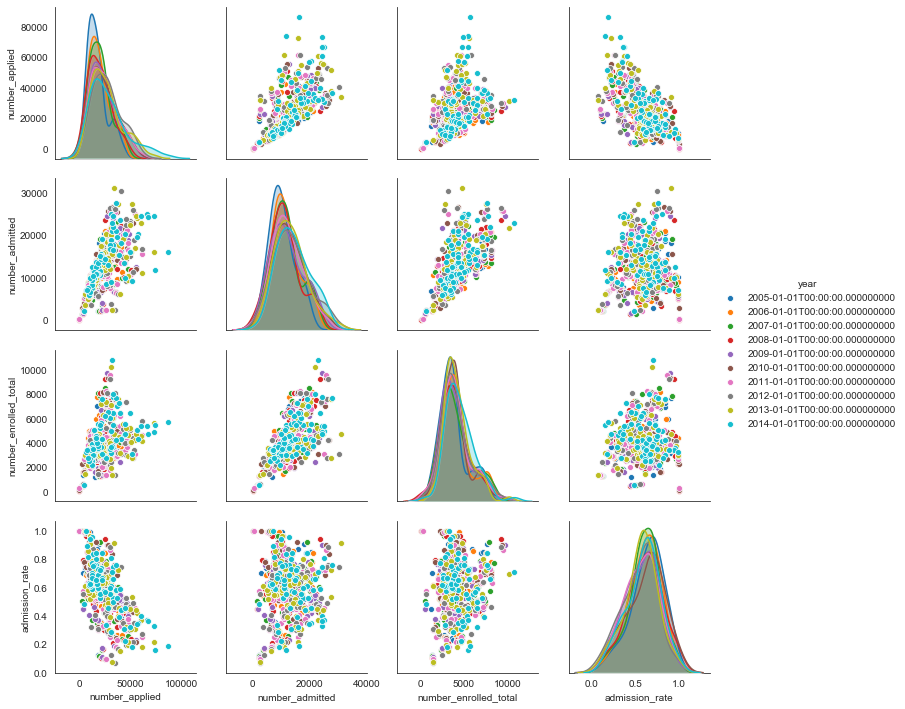

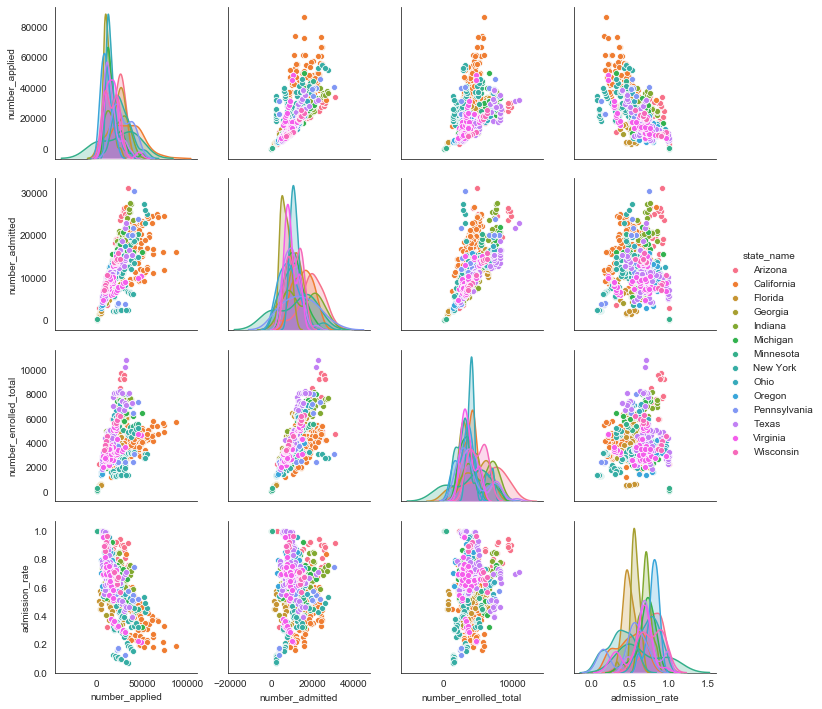

In [47]:
# PAIR-PLOT for ENROLLMENT TRENDS: 
DF = df_Enrollment
sns.set_style('white')

pair_plot = sns.pairplot(DF, hue='year');
pair_plot.savefig(figpathDir+'Enrollment_pair_plot_by_YEAR.png')  

pair_plot = sns.pairplot(DF, hue='state_name');
pair_plot.savefig(figpathDir+'Enrollment_pair_plot_by_STATE.png')  


/Applications/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


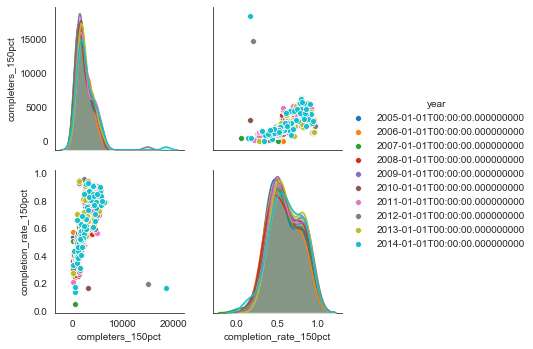

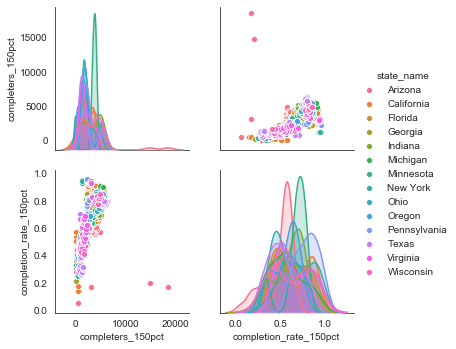

In [48]:
# PAIR-PLOT for GRADUATION TRENDS: 
DF = df_Grad
sns.set_style('white')

pair_plot = sns.pairplot(DF, hue='year');
pair_plot.savefig(figpathDir+'Grad_pair_plot_by_YEAR.png')  

pair_plot = sns.pairplot(DF, hue='state_name');
pair_plot.savefig(figpathDir+'Grad_pair_plot_by_STATE.png')  


/Applications/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


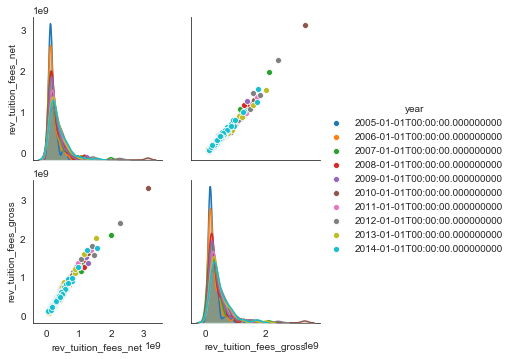

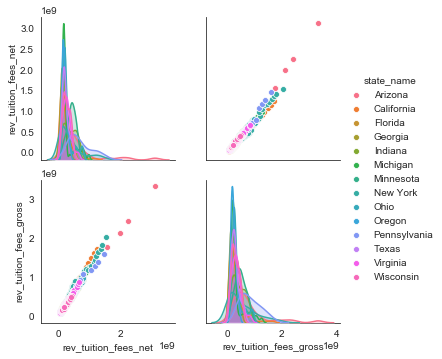

In [49]:
# PAIR-PLOT for Funding-Revenue TRENDS: 
DF = df_Rev
sns.set_style('white')

pair_plot = sns.pairplot(DF, hue='year');
pair_plot.savefig(figpathDir+'Fund_Rev_pair_plot_by_YEAR.png')  

pair_plot = sns.pairplot(DF, hue='state_name');
pair_plot.savefig(figpathDir+'Fund_Rev_pair_plot_by_STATE.png')  


/Applications/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.
/Applications/anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:444: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # will not work for two columns.


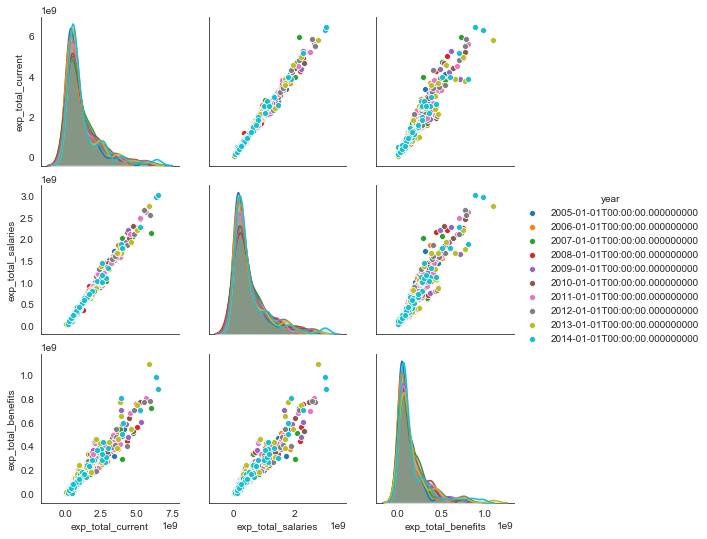

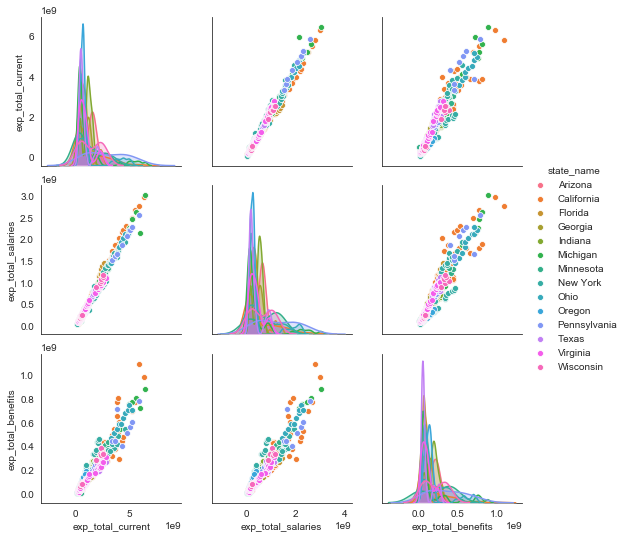

In [50]:
# PAIR-PLOT for Funding-Expenditures TRENDS: 
DF = df_Exp
sns.set_style('white')

pair_plot = sns.pairplot(DF, hue='year');
pair_plot.savefig(figpathDir+'Fund_Exp_pair_plot_by_YEAR.png')  

pair_plot = sns.pairplot(DF, hue='state_name');
pair_plot.savefig(figpathDir+'Fund_Exp_pair_plot_by_STATE.png')  


#### Time series of admission_rate

In [52]:
sns.set()
pvDf_admission_rate = df_Enrollment['']
ad_ts = pvDf_admission_rate.plot(figsize=(12,8),lw=2,title='Admission Rate at Public Universities over Time')
ad_ts.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.ylabel('number admissions / number applicants');

ValueError: view limit minimum -36761.62706406205 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11eb112f0> (for post_execute):


ValueError: view limit minimum -36761.62706406205 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

ValueError: view limit minimum -36761.62706406205 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 864x576 with 1 Axes>

In [55]:
pd.pivot(df_Enrollment

,state_name,inst_name,year,number_applied,number_admitted,number_enrolled_total,admission_rate
0,Arizona,Arizona State University,2005-01-01,NaN,NaN,NaN,NaN
1,Arizona,Arizona State University,2006-01-01,NaN,NaN,NaN,NaN
2,Arizona,Arizona State University,2007-01-01,NaN,NaN,NaN,NaN
3,Arizona,Arizona State University,2008-01-01,24922.0,23504.0,9274.0,0.943102
4,Arizona,Arizona State University,2009-01-01,27089.0,24473.0,9707.0,0.903429
5,Arizona,Arizona State University,2010-01-01,28304.0,25616.0,9344.0,0.905031
6,Arizona,Arizona State University,2011-01-01,29771.0,25795.0,9544.0,0.866447
7,Arizona,Arizona State University,2012-01-01,29722.0,26425.0,9254.0,0.889072
8,Arizona,Arizona State University,2013-01-01,NaN,NaN,NaN,NaN
9,Arizona,Arizona State University,2014-01-01,NaN,NaN,NaN,NaN


In [ ]:
#### Boxplots
sns.boxplot()